In [1]:
import time
from typing import Dict
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
# Dataset
class LoadWindowDataset(Dataset):
    def __init__(self, data_array, window, horizon):
        self.data = data_array
        self.window, self.horizon = window, horizon
        self.n = data_array.shape[0] - window - horizon + 1
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window]                                  # [W, F]
        y_seq = self.data[idx + self.window: idx + self.window + self.horizon, -1:]  # [H, 1] (TOTAL last)
        y_last = y_seq[-1, 0]
        return torch.from_numpy(x).float(), torch.from_numpy(y_seq).float(), torch.tensor([y_last]).float()


In [4]:
# IMPROVED MODEL - Efficient LSTM Forecaster
class EfficientLSTMForecaster(nn.Module):
    """
    Streamlined LSTM forecaster without unused autoencoder components.
    Focuses purely on forecasting with attention mechanism.
    """
    def __init__(self, n_features, window, horizon,
                 hidden_dim=128, latent_dim=64, num_layers=2, 
                 num_heads=4, p_drop=0.2):
        super().__init__()
        self.n_features = n_features
        self.window = window
        self.horizon = horizon
        self.hidden_dim = hidden_dim
        
        # LSTM Encoder - simplified to single configurable multi-layer LSTM
        self.encoder = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=p_drop if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # Layer normalization for encoder output
        self.encoder_ln = nn.LayerNorm(hidden_dim)
        
        # Multi-head attention for better temporal modeling
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            dropout=p_drop,
            batch_first=True
        )
        
        # Context to latent projection
        self.context_proj = nn.Sequential(
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU()
        )
        
        # Forecast head - combines latent context + recent features
        forecast_input_dim = latent_dim + n_features
        self.forecaster = nn.Sequential(
            nn.Linear(forecast_input_dim, 256),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(128, horizon)
        )
    
    def forward(self, x):
        """
        Forward pass for forecasting.
        
        Args:
            x: Input tensor [batch_size, window_length, n_features]
            
        Returns:
            yhat: Forecast tensor [batch_size, horizon, 1]
        """
        batch_size, seq_len, n_features = x.shape
        
        # Encode sequence with LSTM
        encoded_seq, _ = self.encoder(x)  # [B, W, hidden_dim]
        encoded_seq = self.encoder_ln(encoded_seq)
        
        # Self-attention over encoded sequence
        attended_seq, attention_weights = self.attention(
            encoded_seq, encoded_seq, encoded_seq
        )  # [B, W, hidden_dim]
        
        # Global context via mean pooling of attended sequence
        context = attended_seq.mean(dim=1)  # [B, hidden_dim]
        
        # Project context to latent space
        latent_context = self.context_proj(context)  # [B, latent_dim]
        
        # Get most recent features for short-term anchoring
        recent_features = x[:, -1, :]  # [B, n_features]
        
        # Combine context and recent features for forecasting
        forecast_input = torch.cat([latent_context, recent_features], dim=1)
        forecast = self.forecaster(forecast_input)  # [B, horizon]
        
        # Reshape to match expected output format
        yhat = forecast.unsqueeze(-1)  # [B, horizon, 1]
        
        return yhat


In [5]:
# Alternative: Compact version (closer to original)
class CompactLSTMForecaster(nn.Module):
    """
    Compact version - closest to original but without unused parts.
    """
    def __init__(self, n_features, window, horizon,
                 enc_hidden=128, latent_dim=64, p_drop=0.2):
        super().__init__()
        self.n_features = n_features
        self.window = window
        self.horizon = horizon
        
        # Single LSTM encoder
        self.encoder = nn.LSTM(
            input_size=n_features,
            hidden_size=enc_hidden,
            num_layers=2,
            batch_first=True,
            dropout=p_drop
        )
        
        self.encoder_ln = nn.LayerNorm(enc_hidden)
        
        # Simple attention (like original)
        self.attention = nn.Sequential(
            nn.Linear(enc_hidden, enc_hidden),
            nn.Tanh(),
            nn.Linear(enc_hidden, 1)
        )
        
        # Context to latent
        self.to_latent = nn.Sequential(
            nn.Linear(enc_hidden, latent_dim),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(latent_dim, latent_dim)
        )
        
        # Forecaster
        self.forecaster = nn.Sequential(
            nn.Linear(latent_dim + n_features, 128),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(128, horizon)
        )
    
    def forward(self, x):
        """Same logic as original but without unused decoder."""
        batch_size, window_len, n_features = x.shape
        
        # Encode
        h, _ = self.encoder(x)  # [B, W, enc_hidden]
        h = self.encoder_ln(h)
        
        # Attention pooling
        attn_scores = self.attention(h)  # [B, W, 1]
        attn_weights = torch.softmax(attn_scores, dim=1)
        context = (attn_weights * h).sum(dim=1)  # [B, enc_hidden]
        
        # Latent representation
        latent = self.to_latent(context)  # [B, latent_dim]
        
        # Forecast
        recent_features = x[:, -1, :]  # [B, n_features]
        forecast_input = torch.cat([latent, recent_features], dim=1)
        forecast = self.forecaster(forecast_input)  # [B, horizon]
        
        return forecast.unsqueeze(-1)  # [B, horizon, 1]


In [6]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0, verbose=False):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.best_loss = np.inf
        self.wait = 0
        self.should_stop = False
        self.best_state = None
    
    def step(self, val_loss, model=None):
        improved = val_loss < self.best_loss - self.delta
        if improved:
            self.best_loss = val_loss
            self.wait = 0
            if model is not None:
                self.best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: stop after {self.patience} epochs.")
        return improved

In [7]:
# Helper functions 
def infer_5min_freq(index: pd.DatetimeIndex) -> pd.Timedelta:
    freq = pd.infer_freq(index)
    if freq is None:
        diffs = pd.Series(index[1:] - index[:-1])
        step = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=5)
    else:
        step = pd.Timedelta(freq)
    if step != pd.Timedelta(minutes=5):
        print(f"[WARN] Detected step={step}. Script assumes 5-minute cadence.")
    return step

def add_cyclical_time(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    idx = out.index.tz_convert(None) if out.index.tz is not None else out.index
    hour, dow, month = idx.hour, idx.dayofweek, idx.month
    out["sin_hour"]  = np.sin(2*np.pi*hour/24);  out["cos_hour"]  = np.cos(2*np.pi*hour/24)
    out["sin_dow"]   = np.sin(2*np.pi*dow/7);    out["cos_dow"]   = np.cos(2*np.pi*dow/7)
    out["sin_month"] = np.sin(2*np.pi*(month-1)/12); out["cos_month"] = np.cos(2*np.pi*(month-1)/12)
    return out

def add_lags_in_5min(df: pd.DataFrame, spec: dict) -> pd.DataFrame:
    out = df.copy()
    for col, hours in spec.items():
        if col not in out.columns:
            continue
        for h in hours:
            steps = int(h * 12)  # 12 steps/hour
            if steps <= 0:
                continue
            out[f"{col}_lag{h}h"] = out[col].shift(steps)
    return out

def fit_target_scalers_per_year(df: pd.DataFrame, target_col: str) -> Dict[int, MinMaxScaler]:
    """
    Fit a separate MinMaxScaler on TARGET for each calendar year using that year's data only.
    """
    scalers = {}
    years = df.index.year
    for yr in np.unique(years):
        mask = (years == yr)
        sc = MinMaxScaler()
        sc.fit(df.loc[mask, [target_col]])
        scalers[int(yr)] = sc
    return scalers

def transform_target_per_year(df: pd.DataFrame, target_col: str, scalers_by_year: Dict[int, MinMaxScaler]) -> np.ndarray:
    years = df.index.year
    y_scaled = np.empty((len(df), 1), dtype=float)
    for yr, sc in scalers_by_year.items():
        mask = (years == yr)
        if mask.any():
            y_scaled[mask, :] = sc.transform(df.loc[mask, [target_col]])
    return y_scaled

def inverse_target_vector_by_year(y_scaled_1d: np.ndarray, years_for_rows: np.ndarray,
                                  scalers_by_year: Dict[int, MinMaxScaler]) -> np.ndarray:
    """
    Inverse-transform a 1D vector of scaled TARGET values with the scaler corresponding to each row's year.
    """
    assert y_scaled_1d.ndim == 1 and y_scaled_1d.shape[0] == years_for_rows.shape[0]
    y_inv = np.empty_like(y_scaled_1d, dtype=float)
    uyrs = np.unique(years_for_rows)
    for yr in uyrs:
        sc = scalers_by_year[int(yr)]
        mask = (years_for_rows == yr)
        y_inv[mask] = sc.inverse_transform(y_scaled_1d[mask].reshape(-1,1))[:,0]
    return y_inv


In [ ]:
# Main pipeline
from sklearn.preprocessing import StandardScaler


def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load data
    df = pd.read_csv('Demand_with_Temperature.csv', parse_dates=['DateTime'], index_col='DateTime').fillna(0)
    df.index = pd.to_datetime(df.index, format='mixed', errors='raise')
    
    # 5-min cadence check
    _ = infer_5min_freq(df.index)
    
    # Basic cleaning
    for col in ["Outage","Holiday","ECQ","GCQ","ALERT LEVEL 1","ALERT LEVEL 2","ALERT LEVEL 3",
                "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    if "Temperature" in df.columns:
        df["Temperature"] = df["Temperature"].interpolate(limit_direction="both")
    
    # Add cyclical time & lags
    df = add_cyclical_time(df)
    lag_spec = {
        "Temperature": [1, 3, 6, 12, 24],
        "Outage": [1, 3],
        "GCQ": [1, 6],
        "ALERT LEVEL 2": [1, 6],
    }
    df = add_lags_in_5min(df, lag_spec)
    df = df.dropna()  # drop rows introduced by lags
    
    # Window specification: 48h lookback + 48h ahead at 5-min → 576
    W = H = 48 * 12
    
    # Times aligned to post-lag data
    times = df.index[W + H - 1 :]
    
    # Features: everything except TOTAL first, then TOTAL last
    assert "TOTAL" in df.columns, "TOTAL column is required."
    feat_cols = [c for c in df.columns if c != "TOTAL"]
    feats = feat_cols + ["TOTAL"]
    X_all = df[feats].astype(float)
    
    # Data splits
    train_end = pd.Timestamp('2023-12-25 23:59:59.971')
    val_end   = pd.Timestamp('2024-11-25 23:59:59.971')
     
    # SCALING
    # 1) Fit global feature scaler ONLY on train rows; transform all rows
    train_mask_for_scaler = df.index <= train_end
    if not train_mask_for_scaler.any():
        raise ValueError("No rows on/before train_end available to fit the feature scaler.")
    feat_scaler = MinMaxScaler()
    feat_scaler.fit(X_all.loc[train_mask_for_scaler, feat_cols].values)
    X_feats_scaled = feat_scaler.transform(X_all[feat_cols].values)
    
    # 2) Fit target scalers per year; transform target per its own year
    tgt_scalers_by_year = fit_target_scalers_per_year(X_all, "TOTAL")
    y_scaled = transform_target_per_year(X_all, "TOTAL", tgt_scalers_by_year)
    
    # 3) Final array to dataset: [scaled features..., scaled target]
    data = np.hstack([X_feats_scaled, y_scaled])
    n_features = data.shape[1]
    
    # Indices for endpoints (aligned with 'times')
    train_idx = np.where(times <= train_end)[0]
    val_idx   = np.where((times > train_end) & (times <= val_end))[0]
    test_idx  = np.where(times > val_end)[0]
    print(f"Train windows: {len(train_idx)}, Validation windows: {len(val_idx)}, Test windows: {len(test_idx)}")
    if len(times) > 0:
        print(f"First window ts: {times.min()}, Last: {times.max()}")
    assert len(train_idx) > 0 and len(val_idx) > 0 and len(test_idx) > 0
    
    
    
    
    
    # NOTE:
    ########################### try to standardize Y ###########################
    # Flatten Y into 2D for the scaler: (n_samples * H, D)
    scaler = StandardScaler()
    Y_train_flat = Y[train_idx].reshape(-1, D)
    scaler.fit(Y_train_flat)
    
    Y_scaled = Y.copy()
    Y_scaled = Y_scaled.reshape(-1, D)
    Y_scaled = scaler.transform(Y_scaled)
    Y_scaled = Y_scaled.reshape(Y.shape)

    
    
    
    
    
    # Datasets / Loaders
    full_ds = LoadWindowDataset(data, W, H)
    train_ds_pre  = Subset(full_ds, train_idx)
    train_ds_post = Subset(full_ds, val_idx)
    test_ds       = Subset(full_ds, test_idx)
    train_loader_pre  = DataLoader(train_ds_pre,  batch_size=32, shuffle=True,  num_workers=2)
    train_loader_post = DataLoader(train_ds_post, batch_size=32, shuffle=False, num_workers=2)
    test_loader       = DataLoader(test_ds,       batch_size=32, shuffle=False, num_workers=2)
    
    # MODEL - Choose between EfficientLSTMForecaster or CompactLSTMForecaster
    print("\n Using EfficientLSTMForecaster with multi-head attention")
    model = EfficientLSTMForecaster(
        n_features=len(feats), 
        window=W, 
        horizon=H,
        hidden_dim=128, 
        latent_dim=64, 
        num_heads=4, 
        p_drop=0.2
    ).to(device)
    
    # Alternative: Compact version (uncomment to use)
    # print("\n Using CompactLSTMForecaster (minimal changes from original)")
    # model = CompactLSTMForecaster(
    #     n_features=len(feats),
    #     window=W,
    #     horizon=H,
    #     enc_hidden=128,
    #     latent_dim=64,
    #     p_drop=0.2
    # ).to(device)
    
    # Training setup
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    es = EarlyStopping(patience=8, delta=1e-4, verbose=True)
    weights = torch.linspace(0.5, 1.5, steps=H, device=device).view(1, H, 1)
    
    def weighted_mse(pred, target):
        return (weights * (pred - target) ** 2).mean()
    
    f_fn = weighted_mse
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode='min', factor=0.5, patience=3, cooldown=1, min_lr=1e-5
    )
    
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {n_params:,}")
    
    train_losses, val_losses = [], []
    
    # Training Loop
    print("\n Starting training...")
    for ep in range(1, 31):
        t0 = time.time()
        model.train()
        tl = 0.0
        for Xb, Yseqb, _ in train_loader_pre:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            loss = f_fn(yhat, Yseqb)
            opt.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
        train_losses.append(tl / len(train_ds_pre))
        
        # Validation Loop
        model.eval()
        vl, preds_last_scaled, truths_last_scaled = 0.0, [], []
        preds_full_scaled, truths_full_scaled = [], []
        with torch.no_grad():
            for Xb, Yseqb, _ in train_loader_post:
                Xb, Yseqb = Xb.to(device), Yseqb.to(device)
                yhat = model(Xb)
                vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
                preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
                truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
                preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
                truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
        
        val_loss = vl / len(train_ds_post)
        val_losses.append(val_loss)
        sched.step(val_loss)
        
        # Inverse to original units using per-year target scalers
        preds = np.concatenate(preds_last_scaled)        # scaled target
        truths = np.concatenate(truths_last_scaled)      # scaled target
        val_years_last = times[val_idx].year.values      # year of each sample's last step
        inv_p = inverse_target_vector_by_year(preds,  val_years_last, tgt_scalers_by_year)
        inv_t = inverse_target_vector_by_year(truths, val_years_last, tgt_scalers_by_year)
        rm  = root_mean_squared_error(inv_t, inv_p)
        mae = mean_absolute_error(inv_t, inv_p)
        r2  = r2_score(inv_t, inv_p)
        
        # Full-horizon (approximate): use last-step year per sample for all H leads
        pf = np.concatenate(preds_full_scaled, axis=0)   # [N,H] scaled
        tf = np.concatenate(truths_full_scaled, axis=0)  # [N,H] scaled
        inv_pf = inverse_target_vector_by_year(pf.reshape(-1),
                                               np.repeat(val_years_last, H),
                                               tgt_scalers_by_year)
        inv_tf = inverse_target_vector_by_year(tf.reshape(-1),
                                               np.repeat(val_years_last, H),
                                               tgt_scalers_by_year)
        rm_all  = root_mean_squared_error(inv_tf, inv_pf)
        mae_all = mean_absolute_error(inv_tf, inv_pf)
        
        print(f"Ep{ep:02d} Train={train_losses[-1]:.4f} | Val={val_loss:.4f} | "
              f"Val(last) RMSE={rm:.1f} MAE={mae:.1f} R²={r2:.3f} | "
              f"Val(full) RMSE={rm_all:.1f} MAE={mae_all:.1f} | "
              f"Time={time.time()-t0:.1f}s")
        
        _ = es.step(val_loss, model=model)
        if es.should_stop:
            if es.best_state is not None:
                model.load_state_dict(es.best_state)
                if es.verbose:
                    print("EarlyStopping: best weights restored.")
            break
    
    # Training curves
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Weighted MSE'); plt.legend(); plt.title('Loss Curves (tail-weighted)')
    plt.tight_layout(); plt.show()
    
    # Testing Loop
    print("\n Final evaluation on test set...")
    model.eval()
    preds_last_scaled, truths_last_scaled = [], []
    preds_full_scaled, truths_full_scaled = [], []
    test_vl = 0.0
    with torch.no_grad():
        for Xb, Yseqb, _ in DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2):
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            test_vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
            preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
            truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
            preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
            truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
    
    test_loss = test_vl / len(test_ds)
    preds = np.concatenate(preds_last_scaled)
    truths = np.concatenate(truths_last_scaled)
    test_years_last = times[test_idx].year.values
    inv_p = inverse_target_vector_by_year(preds,  test_years_last, tgt_scalers_by_year)
    inv_t = inverse_target_vector_by_year(truths, test_years_last, tgt_scalers_by_year)
    
    mse = mean_squared_error(inv_t, inv_p)
    rm  = root_mean_squared_error(inv_t, inv_p)
    mae = mean_absolute_error(inv_t, inv_p)
    r2  = r2_score(inv_t, inv_p)
    n, p = len(inv_t), len(feats)-1
    adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
    
    # Full-horizon in original units (approximate year handling)
    PH = np.concatenate(preds_full_scaled, axis=0)  # [N,H]
    TH = np.concatenate(truths_full_scaled, axis=0) # [N,H]
    inv_pf = inverse_target_vector_by_year(PH.reshape(-1), np.repeat(test_years_last, H), tgt_scalers_by_year)
    inv_tf = inverse_target_vector_by_year(TH.reshape(-1), np.repeat(test_years_last, H), tgt_scalers_by_year)
    rm_all  = root_mean_squared_error(inv_tf, inv_pf)
    mae_all = mean_absolute_error(inv_tf, inv_pf)
    
    # Hourly-averaged per-lead RMSE (12 steps/hour)
    lead_rmse = []
    for h in range(PH.shape[1]):
        inv_ph = inverse_target_vector_by_year(PH[:, h], test_years_last, tgt_scalers_by_year)
        inv_th = inverse_target_vector_by_year(TH[:, h], test_years_last, tgt_scalers_by_year)
        lead_rmse.append(root_mean_squared_error(inv_th, inv_ph))
    hourly_rmse = np.array(lead_rmse).reshape(-1, 12).mean(axis=1)
    
    print(f"\n FINAL RESULTS:")
    print(f"Test Loss (tail-weighted MSE): {test_loss:.4f}")
    print(f"Final Test Metrics (last step, actual units): "
          f"MSE={mse:.2f}, RMSE={rm:.2f}, MAE={mae:.2f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}")
    print(f"Final Test Metrics (full 48h path): RMSE={rm_all:.2f}, MAE={mae_all:.2f}")
    print("Hourly-averaged RMSE by lead hour (0→47):")
    print(np.array2string(hourly_rmse, precision=2, separator=', '))
    
    # Inference latency (batch=1)
    _ = model(torch.randn(1, W, len(feats)).to(device))
    if device.type == 'cuda':
        torch.cuda.synchronize()
    Nbench = 100
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    total_time = 0.0
    with torch.no_grad():
        for _ in range(Nbench):
            inp = torch.randn(1, W, len(feats)).to(device)
            start.record(); _ = model(inp); end.record()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            total_time += start.elapsed_time(end) / 1000.0
    avg_batch = total_time / Nbench
    print(f"\n Avg inference latency: {avg_batch*1000:.2f} ms/batch • {avg_batch*1000:.2f} ms/sample")
    
    # Plot last-step series
    plt.figure(figsize=(10,4))
    plt.plot(times[test_idx], inv_t, label='Actual')
    plt.plot(times[test_idx], inv_p, label='Predicted', alpha=0.7)
    plt.title("48h-Ahead Forecast – Last-Step (Test)")
    plt.xlabel("Timestamp"); plt.ylabel("TOTAL demand")
    plt.legend(); plt.tight_layout(); plt.show()
    
    # Plot a few full 48h trajectories (first test batch)
    num_show = min(3, len(test_idx))
    if num_show > 0:
        Xb, Yseq

Using device: cuda
Train windows: 1050325, Validation windows: 96767, Test windows: 8641
First window ts: 2013-12-31 00:55:00, Last: 2024-12-25 23:59:59.971000

 Using EfficientLSTMForecaster with multi-head attention
Model parameters: 426,560

 Starting training...
Ep01 Train=0.0070 | Val=0.0068 | Val(last) RMSE=704.5 MAE=406.7 R²=0.542 | Val(full) RMSE=653.9 MAE=397.1 | Time=932.1s
Ep02 Train=0.0063 | Val=0.0060 | Val(last) RMSE=693.9 MAE=403.0 R²=0.555 | Val(full) RMSE=612.4 MAE=373.7 | Time=920.0s
Ep03 Train=0.0062 | Val=0.0060 | Val(last) RMSE=686.5 MAE=397.7 R²=0.565 | Val(full) RMSE=611.9 MAE=370.1 | Time=931.0s
Ep04 Train=0.0061 | Val=0.0060 | Val(last) RMSE=695.1 MAE=409.6 R²=0.554 | Val(full) RMSE=612.1 MAE=375.4 | Time=940.1s
Ep05 Train=0.0061 | Val=0.0062 | Val(last) RMSE=716.0 MAE=418.5 R²=0.527 | Val(full) RMSE=620.7 MAE=379.1 | Time=926.6s
Ep06 Train=0.0060 | Val=0.0059 | Val(last) RMSE=681.5 MAE=404.9 R²=0.571 | Val(full) RMSE=608.0 MAE=375.5 | Time=926.8s
Ep07 Train=0.

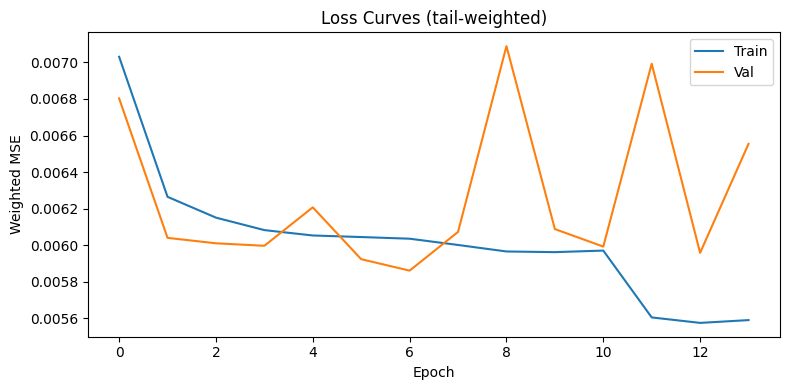


 Final evaluation on test set...

 FINAL RESULTS:
Test Loss (tail-weighted MSE): 0.0054
Final Test Metrics (last step, actual units): MSE=389628.69, RMSE=624.20, MAE=396.96, R²=0.2305, Adj R²=0.2276
Final Test Metrics (full 48h path): RMSE=587.72, MAE=366.73
Hourly-averaged RMSE by lead hour (0→47):
[337.31, 398.43, 428.3 , 456.28, 484.42, 505.55, 529.62, 545.51, 555.2 ,
 565.87, 575.34, 581.15, 586.03, 589.13, 593.98, 601.41, 602.04, 605.44,
 609.58, 608.1 , 603.65, 603.95, 622.74, 634.49, 613.29, 610.85, 602.59,
 603.11, 607.1 , 610.91, 613.65, 611.  , 603.47, 604.72, 607.31, 611.18,
 614.14, 617.34, 622.74, 629.25, 627.86, 630.86, 639.02, 637.67, 630.11,
 622.  , 623.6 , 626.13]

 Avg inference latency: 2.84 ms/batch • 2.84 ms/sample


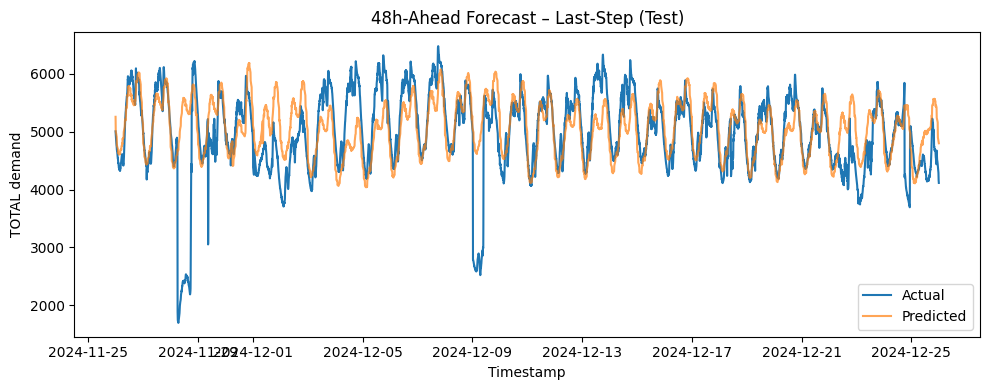

NameError: name 'Yseq' is not defined

In [11]:
main()